### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
(100, 3)
(100,)


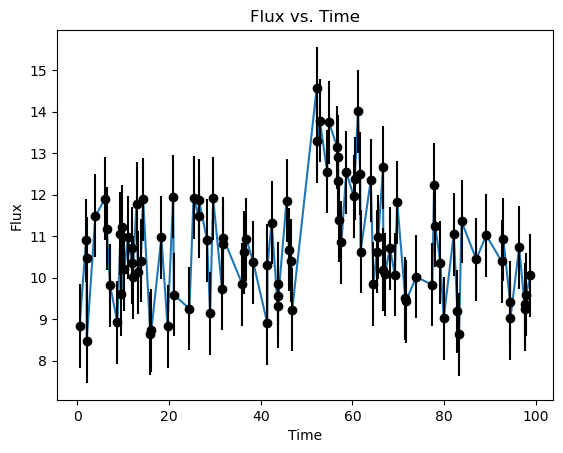

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math 
os.chdir('/home/hoelsczj/repos/astr_8070_S24/coursework/homeworks/hw_data/')
HWData=np.load('hw5_data_1.npy')
time=HWData[:,0]
flux=HWData[:,1]
uncertainty=HWData[:,2]

print(uncertainty)
print(np.shape(HWData))
print(np.shape(time))

plt.plot(time, flux)
plt.errorbar(time, flux, yerr=uncertainty,fmt='o',ecolor = 'black',color='black')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux vs. Time")
plt.show()

def Model1(lnalpha, b, t0, A, time):
    alpha=math.exp(lnalpha)
    if time<t0:
        return b
    else:
        return b+A*math.exp(-alpha*(time-t0))


From Lecture VIII, but now with constant sigma:
$$L \equiv p(\{x_i\}|\mu) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(modelvalue_i-datavalue_i)^2}{2\sigma^2}\right).$$

In [2]:
import scipy 
def LogLikelihood(x):
    lnalpha=x[0]
    b=x[1]
    t0=x[2]
    A=x[3]
    LogLikelihood=0
    index=0
    for index in range(len(flux)):
        datavalue=flux[index]
        modelvalue=Model1(lnalpha, b, t0, A, time[index])
        sigma=1 #constant uncertainty here, = 1 
        #This is found by taking the natural log of the likelihood written above. 
        LogLikelihood=LogLikelihood+((-(datavalue-modelvalue)**2)/(2*sigma*sigma))-np.log(sigma*np.sqrt(2*np.pi))
        #I applied the fact that the Log of a product is the sum of the logs of the terms that are multiplied. 
    return LogLikelihood 

In [3]:

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

def logPrior(x):
    lnalpha=x[0]
    b=x[1]
    t0=x[2]
    A=x[3]
    if 0<b<50 and 0<A<50 and 0<t0<100 and -5<lnalpha<5:
        return np.log((1/50)*(1/50)*(1/100)*(1/10)) #Return log of product of uniform priors in range where nonzero
    else:
        return -1*np.inf #when any prior is zero, the product is also zero, thus the log is negative infinity 

# we have 4 parameters 
ndim = 4

# initial jump covar. matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize the mcmc sampler
sampler = ptmcmc(ndim, LogLikelihood, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)


Optional mpi4py package is not installed.  MPI support is not available.


In [4]:
# sampler for N steps
N = int(1000000)
x0 = np.array([1.2, 10.2, 55, 15])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 1.00 percent in 2.927722 s Acceptance rate = 0.398533Adding DE jump with weight 50
Finished 100.00 percent in 322.048598 s Acceptance rate = 0.388334
Run Complete


In [5]:
# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

print(chain)
print(np.shape(chain))

[[   1.2          10.2          55.         ... -193.238839
     0.            1.        ]
 [   1.18568499   10.66233595   55.05819908 ... -178.904608
     0.982         1.        ]
 [   1.23423937   10.64009524   55.07621769 ... -179.172925
     0.982         1.        ]
 ...
 [  -1.77721571   10.39033415   47.23894435 ... -142.376024
     0.388334      1.        ]
 [  -1.88316496   10.36723018   47.34412687 ... -141.840231
     0.388334      1.        ]
 [  -2.00507484   10.26043805   49.25539299 ... -143.735964
     0.388334      1.        ]]
(100001, 8)


In [6]:
import acor
acor.acor(chain[:,0]) 
print(acor.acor(chain[:,0])) #autocorrelation length for lnalpha is first element 
print(acor.acor(chain[:,1])) #autocorrelation length for b is second element 
print(acor.acor(chain[:,2])) #t0
print(acor.acor(chain[:,3])) #A
# the first element of the tuple is the length between independent samples.
# thin by the nearest integer.

(65.32711526584735, -2.093612547946514, 0.0066624966744721495)
(7.325234683554545, 10.29741369427876, 0.0010436081783558148)
(11.121316746918504, 49.252667735494896, 0.016318968404602136)
(15.986402910542642, 5.710566926279044, 0.021248058747703375)


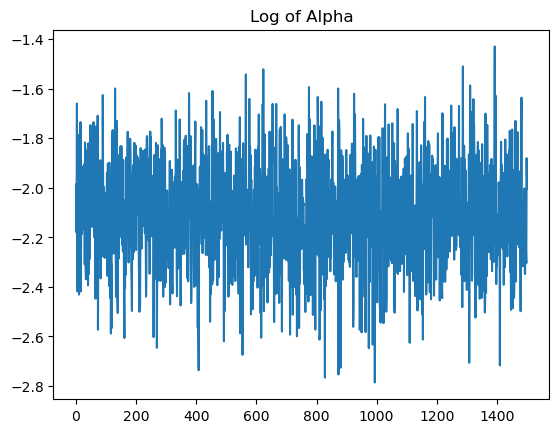

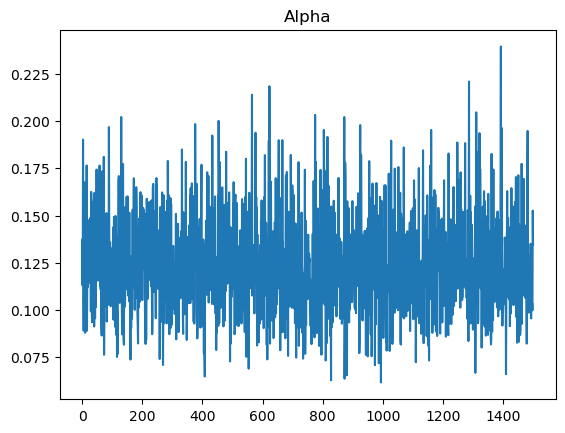

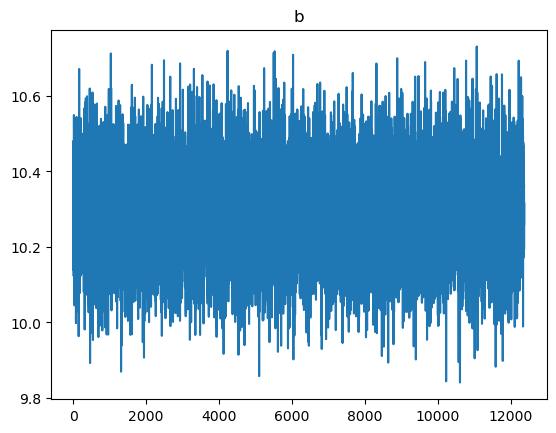

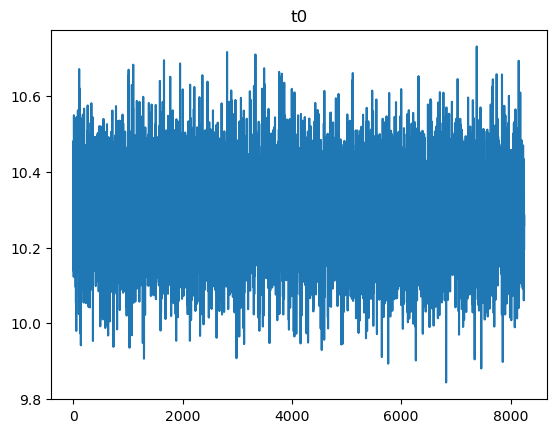

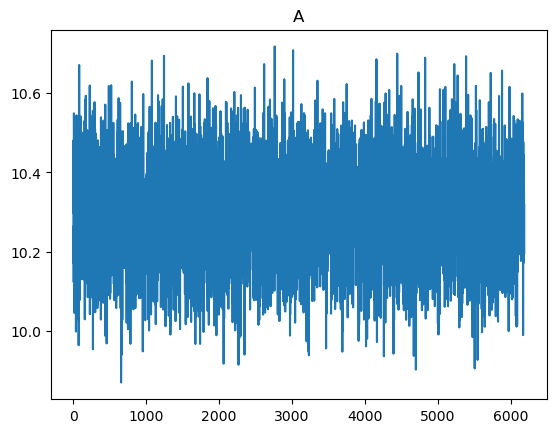

<Figure size 640x480 with 0 Axes>

In [7]:
burninalpha=1000
burninb=1000
burnint0=1000
burninA=1000 #Remove first 1000 points as burn in 

AutoCorrAlpha=int(np.ceil(acor.acor(chain[:,0])[0])) #Remove burn in and select points every auto correlation length 
AutoCorrB=int(np.ceil(acor.acor(chain[:,1])[0]))
AutoCorrT0=int(np.ceil(acor.acor(chain[:,2])[0]))
AutoCorrA=int(np.ceil(acor.acor(chain[:,3])[0]))
lnalphachain=chain[burninalpha:,0][0::AutoCorrAlpha]  
bchain=chain[burninb:,1][0::AutoCorrB]
t0chain=chain[burnint0:,1][0::AutoCorrT0]
Achain=chain[burninA:,1][0::AutoCorrA]

plt.plot(lnalphachain) #Plotting each trace plot 
plt.title("Log of Alpha")
plt.show() 
plt.clf()
    
alphavalues=[]
for element in lnalphachain:
    alphavalues.append(math.exp(element))
plt.plot(alphavalues) #Plotting each trace plot 
plt.title("Alpha")
plt.show() 
plt.clf()

plt.plot(bchain)
plt.title("b")
plt.show() 
plt.clf()

plt.plot(t0chain)
plt.title("t0")
plt.show() 
plt.clf()

plt.plot(Achain)
plt.title("A")
plt.show() 
plt.clf()



Making Corner Plots:

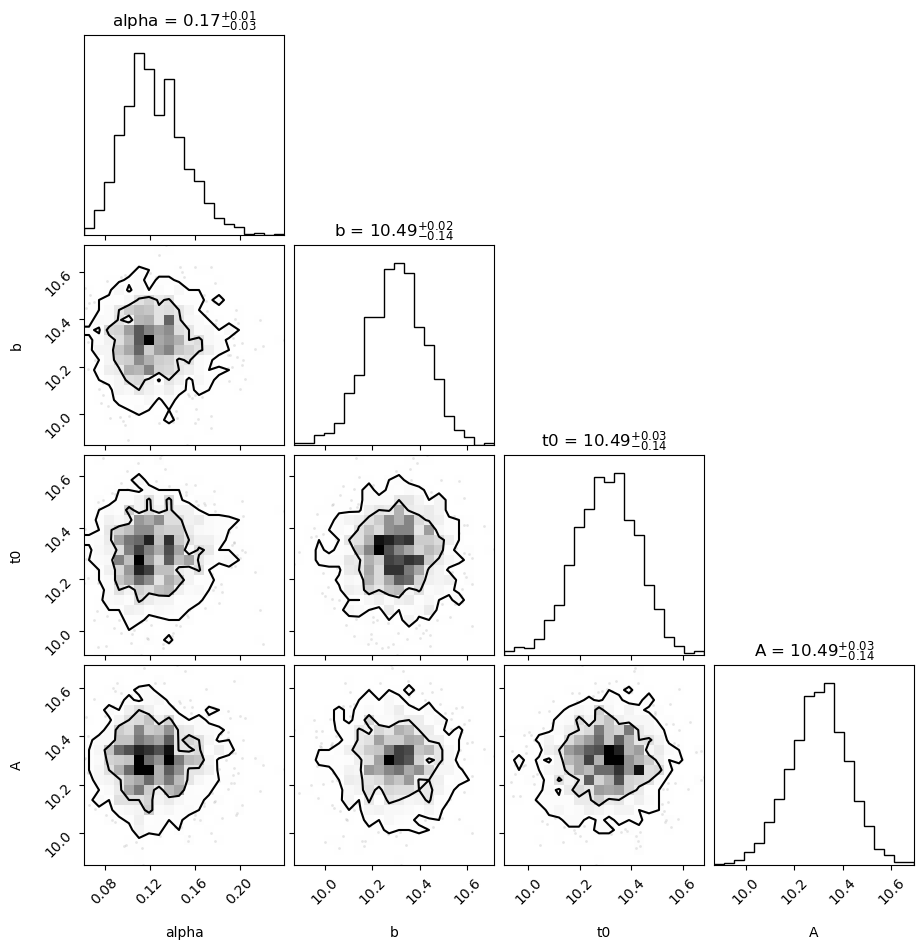

In [8]:
import corner #Making corner plots here 
Corner_Plot_Data=[] #Initialize empty list 
alphachain=[]
for index in range(0, len(lnalphachain)):
    alphachain.append(math.exp(lnalphachain[index])) #taking exp of this chain, which has log alpha values in it 
for index in range(0,len(alphachain)): #working with the shortest one 
    Corner_Plot_Data.append([alphachain[index], bchain[index], t0chain[index], Achain[index]])
Corner_Plot_Data=np.array(Corner_Plot_Data) #Convert list to array 

#Make the corner plot with labels and titles, 68% and 95% for levels 
fig = corner.corner(Corner_Plot_Data, levels=(0.68,0.95), title_quantiles=[0.68, 0.95, 0.97], labels=["alpha", "b", "t0", "A"], show_titles=True)

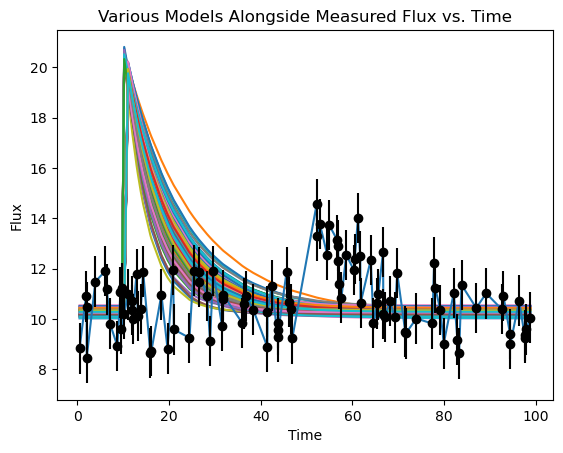

In [9]:

import random 
for n in range(0,100): #I randomly sample 100 times 
    index=random.randint(0,len(alphachain)-1)
    alpha=alphachain[index]
    b=bchain[index] #I randomly generate the index which I use to pull out these values.
    #These become the parameter values used to generate curves in a bit. 
    A=Achain[index]
    t0=t0chain[index]
    ModelValues=[] #initialize empty list to hold each model 
    for timevalue in time: #generating model values at each time value in the time list 
        ModelValues.append(Model1(math.log(alpha), b, t0, A, timevalue))
    plt.plot(time, ModelValues) #plot the model generated 
plt.plot(time, flux) #plot the data 
plt.errorbar(time, flux, yerr=uncertainty,fmt='o',ecolor = 'black',color='black')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Various Models Alongside Measured Flux vs. Time")
plt.show()  
    
    

For some reason this mcmc package is giving me a value around 10 for t0, when it should be closer to 55. I don't understand why it is doing this. Dynesty finds a much higher value later in this notebook...

Here I apply Dynesty to the Gaussian Model, then I'll do the original model next. 

In [34]:
def Model2(lnalpha, b, t0, A, lnsigmaw, time): #Second model to test 
    alpha=math.exp(lnalpha)
    sigmaw=math.exp(lnsigmaw)
    return b+A*math.exp(-alpha*(time-t0)/(2*sigmaw*sigmaw))

In [35]:
import dynesty

# Define the dimensionality of our problem.
ndim = 5

# Define our priors
def ptform(u):
    u[0]=5*(2*u[0]-1) #-5 to 5 for ln alpha
    u[1]=u[1]*50 #0 to 50 for b
    u[2]=100*u[2] #0 to 100 for t0
    u[3]=50*u[3] #0 to 50 for A
    u[4]=2*(2*u[4]-1) #-2 to 2 for ln sigmaW
    return u 

In [36]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

7682it [01:59, 64.15it/s, +500 | bound: 236 | nc: 1 | ncall: 194596 | eff(%):  4.215 | loglstar:   -inf < -140.659 <    inf | logz: -155.231 +/-  0.168 | dlogz:  0.001 >  0.509]


In [37]:
summary=sampler.results.summary()
print(summary)

from dynesty import utils as dyfunc
#Pull out results 
oursamples = sresults.samples  # samples
ourweights = np.exp(sresults.logwt - sresults.logz[-1])  # weights normalized 

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=ourweights)
             for samps in oursamples.T]
print("68 percent credible regions for ln alpha, b, t0, A, and sigmaW: ")
print(str(quantiles))

Summary
nlive: 500
niter: 7682
ncall: 194096
eff(%):  4.215
logz: -155.231 +/-  0.299
None
68 percent credible regions for ln alpha, b, t0, A, and sigmaW: 
[[-2.3126352427393426, -1.8850567782386887], [10.177244824280837, 10.421922114478384], [47.54334435337159, 51.109899779039004], [4.1959925492971255, 7.211383542044078], [-1.4251789487067463, 1.3302668789605265]]


We thus see that the log of the evidence is estimated as -155.231, so the evidence is estimated as exp(-155.231). 

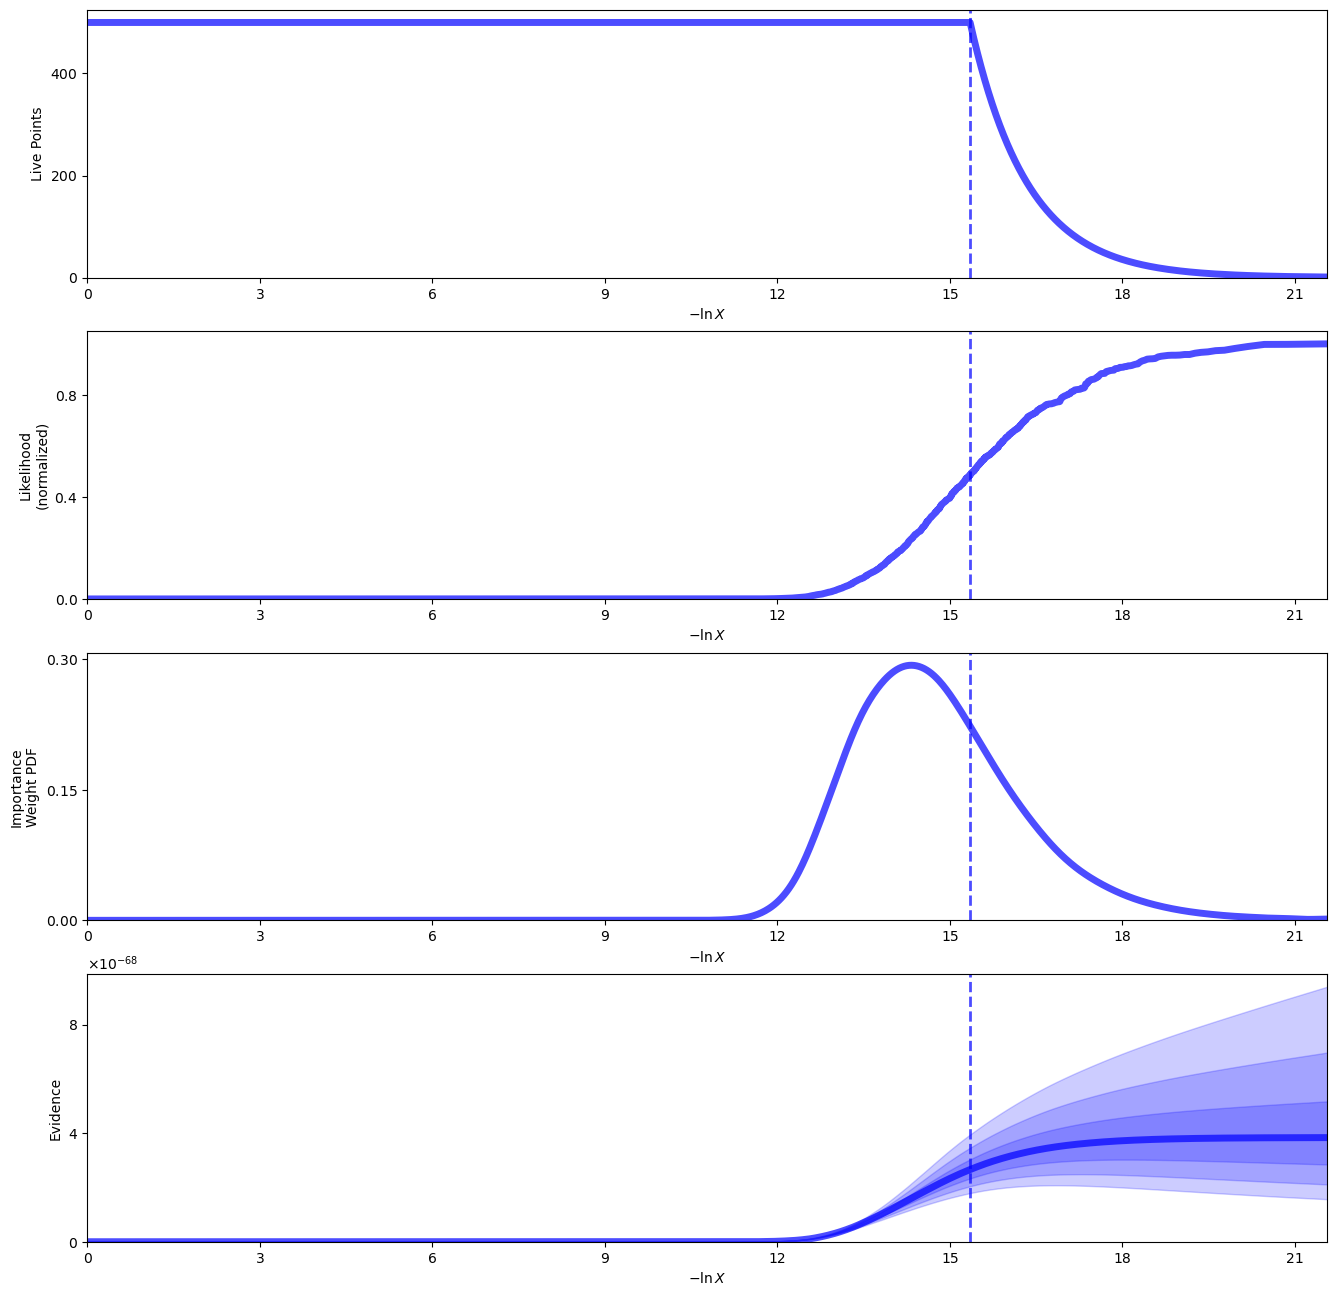

In [38]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

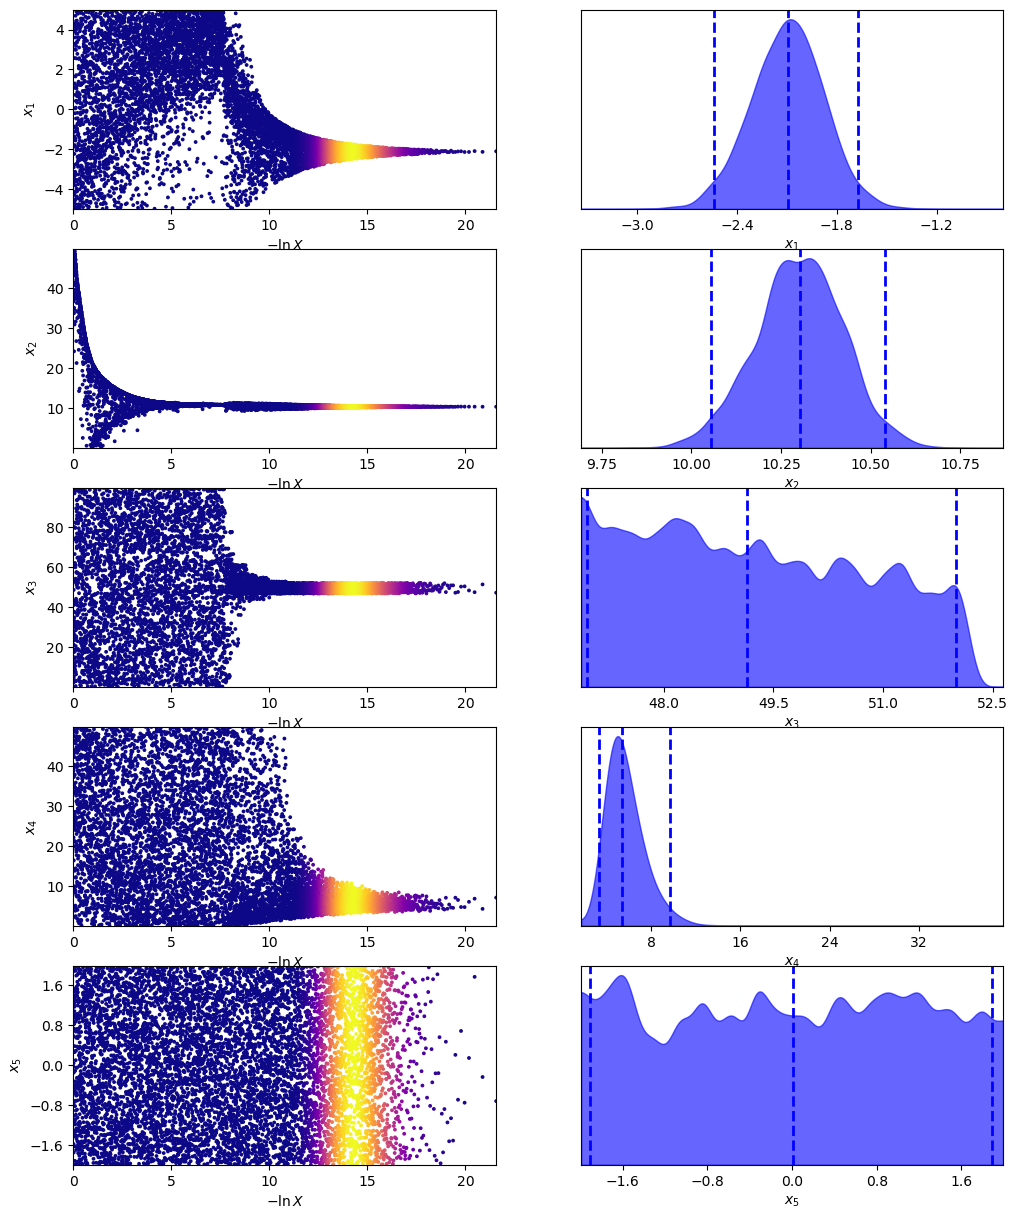

In [39]:
tfig, taxes = dyplot.traceplot(sresults)

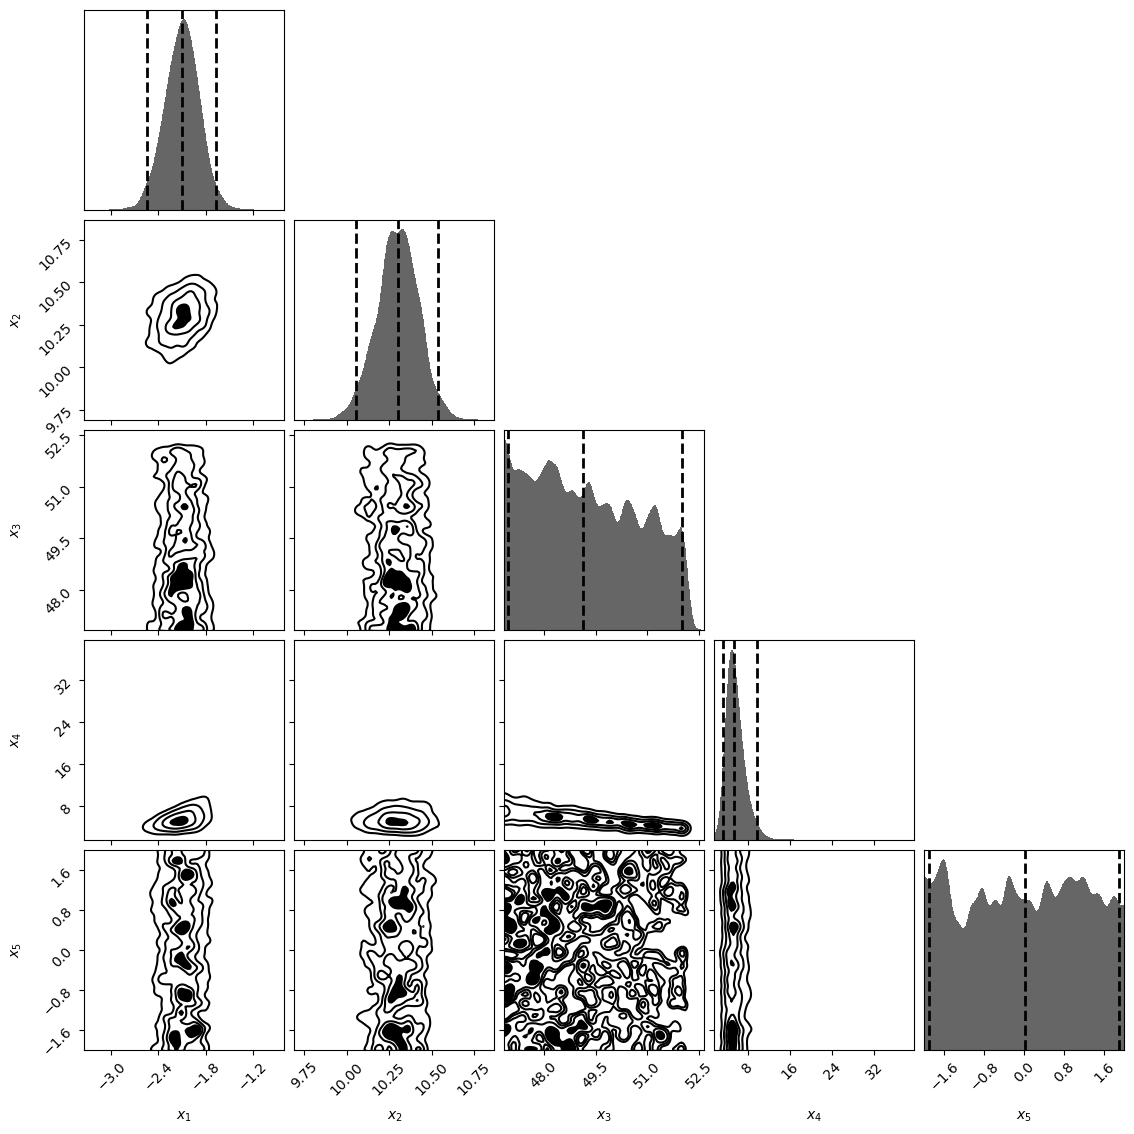

In [40]:
cfig, caxes = dyplot.cornerplot(sresults)

Now I'll do this again with the original model. 

In [27]:
def ptform2(u):
    u[0]=5*(2*u[0]-1) #-5 to 5 for ln alpha
    u[1]=u[1]*50 #0 to 50 for b
    u[2]=100*u[2] #0 to 100 for t0
    u[3]=50*u[3] #0 to 50 for A
    return u 
ndim=4 #four parameters here 
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform2, ndim)
sampler.run_nested()
sresults = sampler.results


4087it [00:52, 20.78it/s, bound: 92 | nc: 60 | ncall: 87449 | eff(%):  4.674 | loglstar:   -inf < -178.514 <    inf | logz: -185.488 +/-  0.109 | dlogz: 35.768 >  0.509]    /home/hoelsczj/miniconda3/envs/astro8070/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4093it [00:53, 11.21it/s, bound: 94 | nc: 403 | ncall: 88906 | eff(%):  4.604 | loglstar:   -inf < -178.482 <    inf | logz: -185.484 +/-  0.109 | dlogz: 35.753 >  0.509]/home/hoelsczj/miniconda3/envs/astro8070/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determ

In [28]:
summary=sampler.results.summary()
print(summary)

from dynesty import utils as dyfunc
#Pull out results 
oursamples = sresults.samples  # samples
ourweights = np.exp(sresults.logwt - sresults.logz[-1])  # weights normalized 

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=ourweights)
             for samps in oursamples.T]
print("68 percent credible regions for ln alpha, b, t0, and A: ")
print(str(quantiles))

Summary
nlive: 500
niter: 7769
ncall: 134638
eff(%):  6.142
logz: -155.414 +/-  0.300
None
68 percent credible regions for ln alpha, b, t0, and A: 
[[-2.3125747135958483, -1.8905964334984404], [10.169459937164357, 10.413177664973519], [47.56768517251653, 51.172647666831644], [4.137248738298004, 7.127068820755564]]


We thus see that the log of the evidence is estimated as -155.414, so the evidence is estimated as exp(-155.414). This hardly any different from the other model. Also, notice that the value of t0 is found to be close to 50, which is far more reasonable than what I got with the first mcmc package. Not sure what was wrong there. 

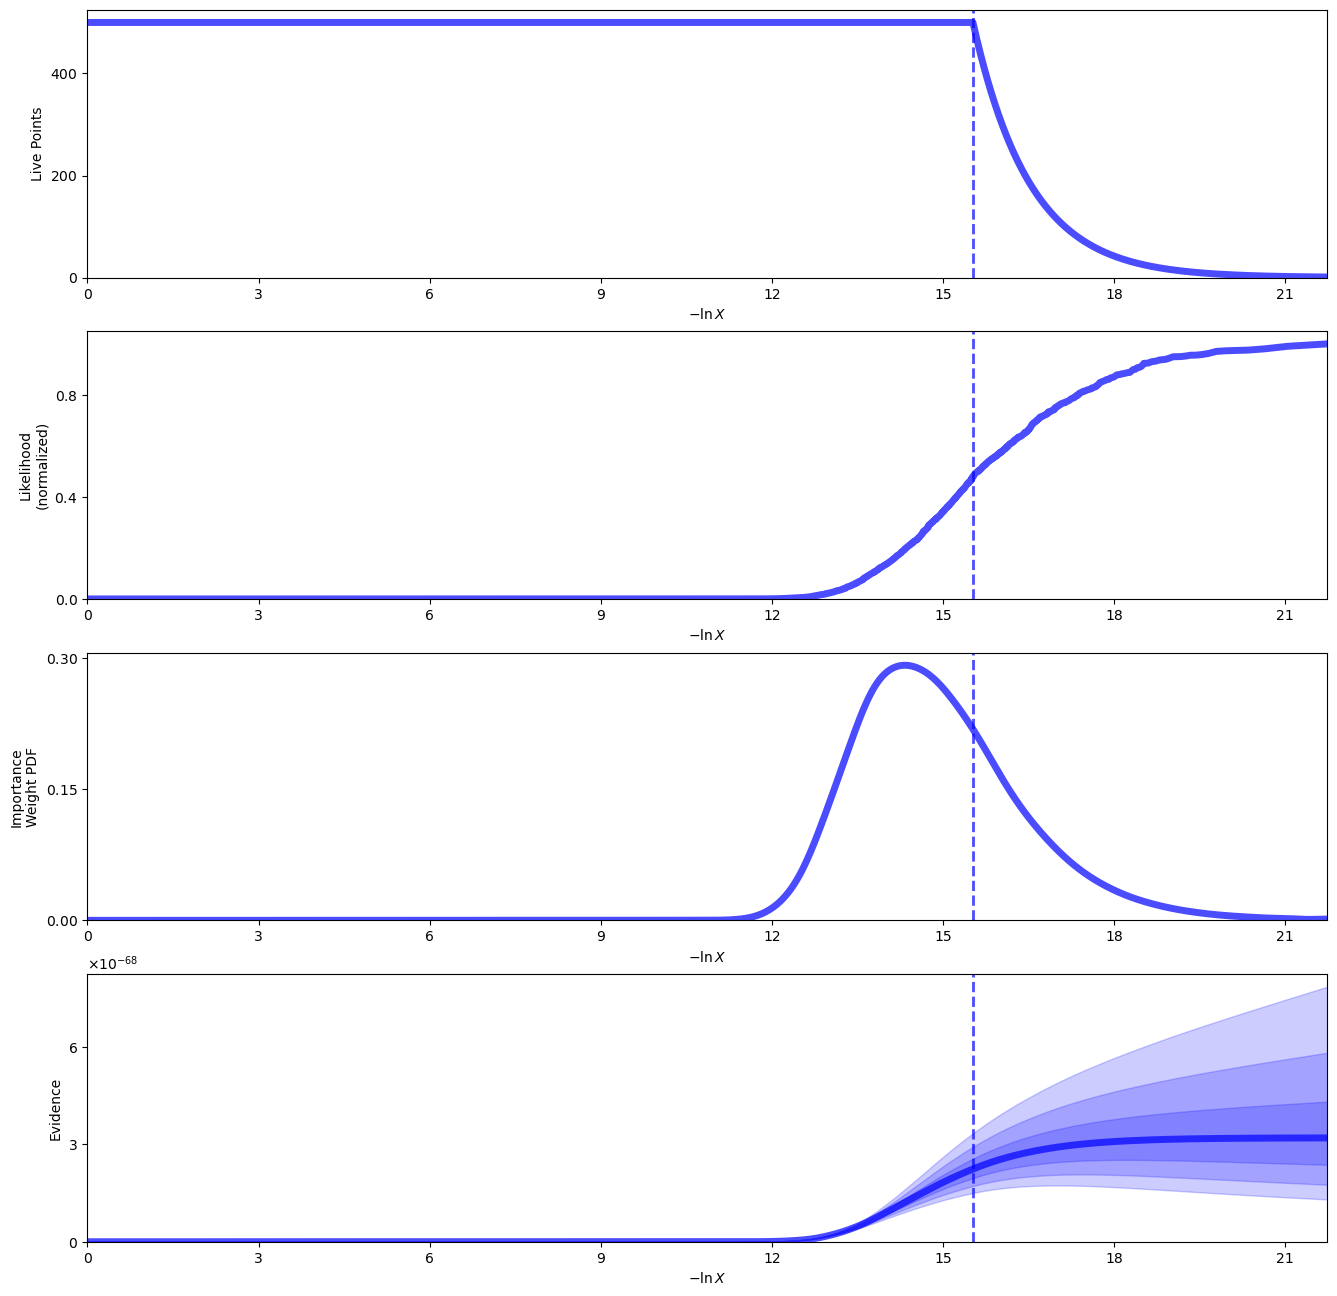

In [29]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

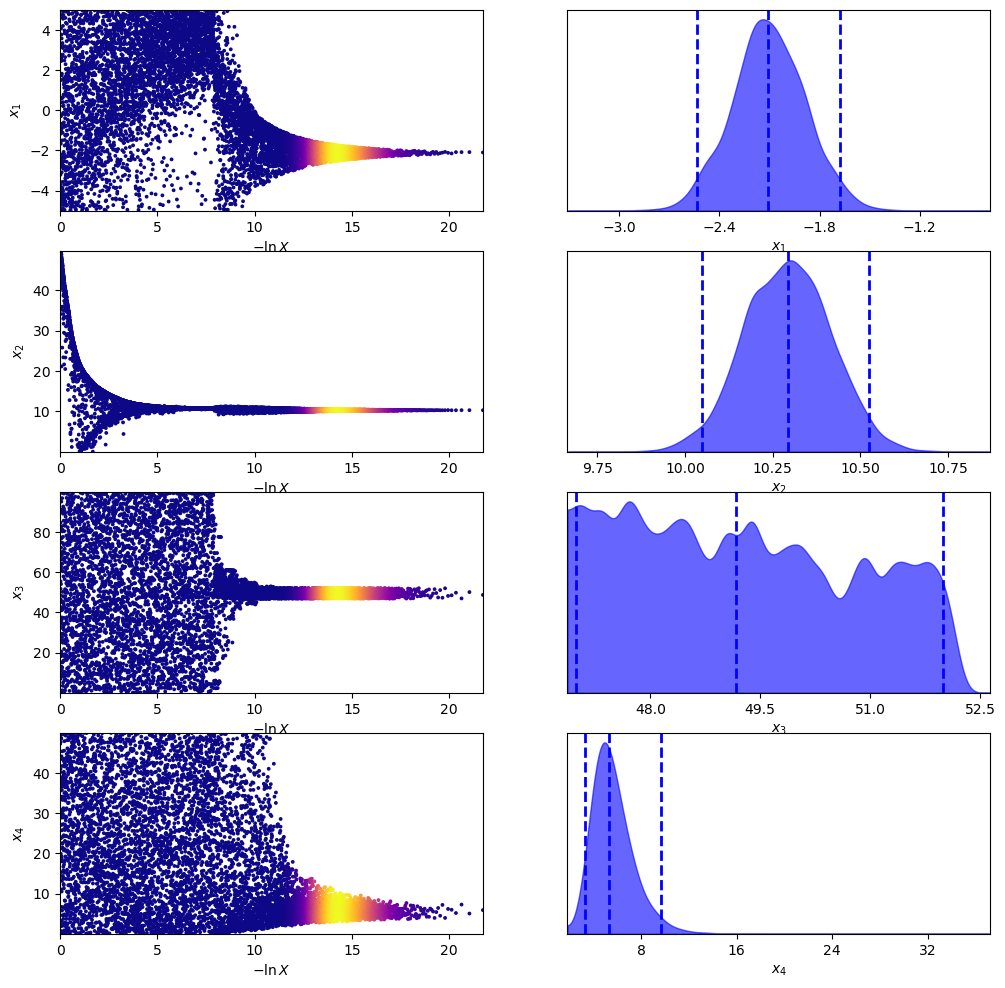

In [30]:
tfig, taxes = dyplot.traceplot(sresults)

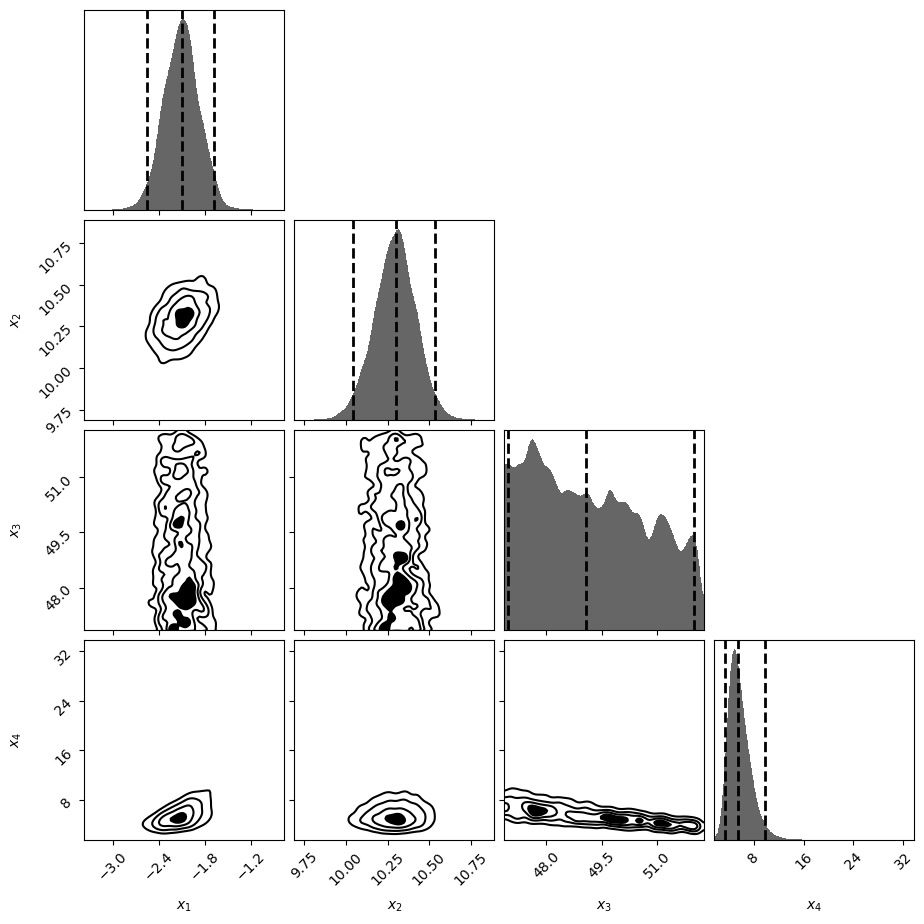

In [26]:
cfig, caxes = dyplot.cornerplot(sresults)

This corner plot looks questionable/different from what I got with the other mcmc package. There may be a problem with one or the other. 

Bayes Factor (evidence for Gaussian model divided by evidence for the original model):

In [41]:
BayesFactor=math.exp(-155.231)/math.exp(-155.414)
print("Bayes Factor: ")
print(BayesFactor)

Bayes Factor: 
1.200814408080822


This Bayes factor is barely above 1, so I am not seeing any notable preference for the Gaussian model, assuming my analysis is correct. There is a slight preference for the Gaussian, though not enough to really call it a preference. I would say neither is preferred over the other in any meaningful way, if this is accurate. Given that the first (non Gaussian) model is simpler, I would go with it. 